In [2]:
# Check the column names in the DataFrame
print(df.columns)


Index(['prompt', 'essay', 'evaluation', 'band'], dtype='object')


In [7]:
# Remove leading and trailing whitespaces and carriage returns
df['band'] = df['band'].str.strip()

# Remove any remaining control characters
df['band'] = df['band'].str.replace(r'[\r\n]', '', regex=True)

# Convert to numeric, forcing errors to NaN
df['band'] = pd.to_numeric(df['band'], errors='coerce')





In [8]:
# Replace '<4' with a specific number, or drop them
df['band'] = df['band'].replace('<4', 4)
df['band'] = pd.to_numeric(df['band'], errors='coerce')


In [9]:
print(df['band'].head())


0    5.0
1    6.0
2    4.0
3    8.0
4    6.0
Name: band, dtype: float64


In [11]:
# Re-attempt to convert the 'band' column to numeric, forcing errors to be NaN
df['band'] = pd.to_numeric(df['band'], errors='coerce')

# Check if there are any NaN values after conversion
nan_values = df['band'].isna().sum()
print(f"Number of NaN values in 'band' column after conversion: {nan_values}")

# If there are NaN values, inspect the rows
if nan_values > 0:
    print(df[df['band'].isna()])

# You may need to drop or fill these NaN values depending on your use case
df = df.dropna(subset=['band'])


Number of NaN values in 'band' column after conversion: 572
                                                 prompt  \
29    In many countries, more and more young people ...   
44    Some believe that people are naturally born le...   
46    Some believe that people are naturally born le...   
78    Every day, millions of tons of food are wasted...   
85    Every day, millions of tons of food are wasted...   
...                                                 ...   
9861  Some people believe that studying at universit...   
9864  Education for young people is important in man...   
9896  Some people think that museums should be enjoy...   
9902  People nowadays tend to have children at older...   
9906  The best way to teach children to cooperate is...   

                                                  essay  \
29    Modern society has been facing the problem a d...   
44    It is a common belief that leadership is given...   
46    Leadership is an attribute which makes people ..

In [12]:
# Drop rows with NaN in the 'band' column
df = df.dropna(subset=['band'])

# Convert the 'band' column to float, just in case
df['band'] = df['band'].astype(float)


In [13]:
# Impute NaN values with the mean of the column
df['band'] = df['band'].fillna(df['band'].mean())

# Alternatively, you could use median or a constant value
# df['band'] = df['band'].fillna(df['band'].median())
# df['band'] = df['band'].fillna(0)  # or some other value


In [14]:
# For manual inspection, you can view the problematic rows
print(df[df['band'].isna()])

# After inspection, manually update the values as needed
# Example:
# df.loc[29, 'band'] = 6.0  # if you determine the correct value


Empty DataFrame
Columns: [prompt, essay, evaluation, band, length, lexical_diversity, grammar_errors]
Index: []


In [16]:
# Drop the non-numeric columns before training the model
X = df.drop(columns=['band', 'prompt', 'essay', 'evaluation'])


In [17]:
# Example of one-hot encoding categorical features
X = pd.get_dummies(df.drop(columns=['band']), drop_first=True)


In [18]:
from sklearn.model_selection import train_test_split

# Define target and feature variables
y = df['band'].astype(float)  # Ensure 'band' is float
X = df.drop(columns=['band', 'prompt', 'essay', 'evaluation'])  # Drop non-numeric columns

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 7472, number of used features: 3
[LightGBM] [Info] Start training from score 6.304336


LGBMRegressor()

In [19]:
# Predict on the test set
y_pred = model.predict(X_test)

# Import metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Calculate and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 1.4617483494269161
R-squared: 0.08684620425097467


In [23]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# Load your trained model
# model = lgb.LGBMRegressor().fit(X_train, y_train)  # Replace this with actual model loading if needed

def extract_features(essay):
    """
    Extract features from the essay.
    """
    # Feature 1: Essay length
    length = len(essay)
    
    # Feature 2: Lexical diversity
    words = re.findall(r'\b\w+\b', essay)
    lexical_diversity = len(set(words)) / len(words) if words else 0
    
    # Feature 3: Grammar errors (using TextBlob for simplicity; this is just an example)
    blob = TextBlob(essay)
    grammar_errors = len(blob.correct().string) - len(essay)
    
    return [length, lexical_diversity, grammar_errors]

def predict_band_score():
    try:
        # Collect essay text from user
        essay = input("Enter your essay: ")
        
        # Extract features from the essay
        features = extract_features(essay)
        
        # Create a new data point with the extracted features
        new_data = [features]
        
        # Predict the band score using the trained model
        predicted_band = model.predict(new_data)
        
        # Print the predicted band score
        print(f'Predicted band score: {predicted_band[0]:.2f}')

    except Exception as e:
        print(f"An error occurred: {e}")

# Call the function to predict the band score
predict_band_score()



Enter your essay: "International sports events require the most well-trained athletes for each country, in order to achieve this goal countries make an effort to build infrastructure designed to train top athletes. Although this policy can indeed make fewer sports facilities for ordinary people, investing in the best athletes is vital to develop competitive sports performances in each country. On the one hand, building specific infrastructure for the best athletes is crucial in order to get better results at international sports events such as The Olympics or the World Cup. The importance of getting better results is that it creates awareness of the importance of sports in society and motivates more people to do a sport. In this way, investing in these developments can help countries to develop an integral sport policy that can benefit everyone. On the other hand, one can argue that a negative effect could be that less infrastructure is built for the rest of the people. However, people

In [24]:
import pandas as pd

# Assuming df is your DataFrame and 'band', 'prompt', 'essay', 'evaluation' columns are dropped
X = df.drop(columns=['band', 'prompt', 'essay', 'evaluation'])

# Display the remaining columns and their data types
print("Remaining columns and their data types:")
print(X.dtypes)

# Display the first few rows of the remaining data
print("\nFirst few rows of the remaining data:")
print(X.head())


Remaining columns and their data types:
length               float64
lexical_diversity    float64
grammar_errors       float64
dtype: object

First few rows of the remaining data:
   length  lexical_diversity  grammar_errors
0   369.0           0.501355             6.0
1   255.0           0.619608             3.0
2   256.0           0.632812            10.0
3   295.0           0.644068             9.0
4   264.0           0.685606             5.0


In [46]:
import json

# Define a simple tokenizer and vocabulary
tokenizer = {'basic_english': 'basic_english'}  # Example; adjust according to your needs
vocab = {'the': 1, 'quick': 2, 'brown': 3, 'fox': 4, '<unk>': 0}  # Example; adjust according to your needs

# Save tokenizer to JSON file
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer, f)

# Save vocabulary to JSON file
with open('vocab.json', 'w') as f:
    json.dump(vocab, f)


In [54]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict, Dataset

# Load the dataset
dataset = load_dataset("chillies/IELTS_essay_human_feedback")

# Initialize the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Define the preprocess function
def preprocess_function(examples):
    inputs = examples['essay']
    targets = examples['chosen']
    
    # Tokenize inputs with padding
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding='max_length')
    
    # Tokenize targets with padding
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding='max_length')
    
    model_inputs['labels'] = labels['input_ids']
    
    # Make sure the labels are not masked for padding
    model_inputs['labels'] = [-100 if label == tokenizer.pad_token_id else label for label in model_inputs['labels']]
    
    return model_inputs

# Split the test dataset into train and eval
test_split = dataset['test']
split_index = int(len(test_split) * 0.8)  # 80% for training and 20% for evaluation

train_dataset = test_split.select(range(split_index))
eval_dataset = test_split.select(range(split_index, len(test_split)))

# Preprocess the datasets
encoded_train_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    output_dir='./results'
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_eval_dataset  # Provide the evaluation dataset here
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('t5-ielts-feedback')
tokenizer.save_pretrained('t5-ielts-feedback')

# Function to generate feedback
def generate_feedback(input_text):
    model.eval()
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    feedback = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return feedback

# Example usage
if __name__ == "__main__":
    while True:
        user_input = input("Enter your essay for feedback or 'quit' to exit: ").strip()
        if user_input.lower() == 'quit':
            break
        
        feedback = generate_feedback(user_input)
        print(f"Feedback: {feedback}")


Map:   0%|          | 0/1409 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.861400,1.336173
2,1.441000,1.137589
3,1.394500,1.099573


Enter your essay for feedback or 'quit' to exit: "Human beings are facing many challenges nowadays. Poverty is always an critical topic among countries, especially the poverty in developing countries. Developed countries frequently offer financial support to poor countries but the poverty still exist. Experts are arguing that developed countries should consider other solutions to help solve the poverty issue. I believe this is a much better direction compare to money support only. Money is essential to many factors like food, contruction and hospital. With money provided by developed countries, govenment can improve the inforstructure, supporting poor family with food, building more houses for the poor people, builing more schools to support children's education, which is critical for people to get out of poverty. But money cannot solve everything. The poverty caused by many reasons like lacking of resource and experienced governor. None of them could be solved by simply offering money

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [55]:
import torch

# Function to generate feedback
def generate_feedback(input_text):
    model.eval()
    
    # Move model to CPU (or device of choice) for inference
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    
    # Tokenize input and move tokens to the same device
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    
    # Generate outputs
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    
    # Decode the output and move it back to CPU
    feedback = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return feedback

# Example usage
if __name__ == "__main__":
    while True:
        user_input = input("Enter your essay for feedback or 'quit' to exit: ").strip()
        if user_input.lower() == 'quit':
            break
        
        feedback = generate_feedback(user_input)
        print(f"Feedback: {feedback}")


Enter your essay for feedback or 'quit' to exit: "Human beings are facing many challenges nowadays. Poverty is always an critical topic among countries, especially the poverty in developing countries. Developed countries frequently offer financial support to poor countries but the poverty still exist. Experts are arguing that developed countries should consider other solutions to help solve the poverty issue. I believe this is a much better direction compare to money support only. Money is essential to many factors like food, contruction and hospital. With money provided by developed countries, govenment can improve the inforstructure, supporting poor family with food, building more houses for the poor people, builing more schools to support children's education, which is critical for people to get out of poverty. But money cannot solve everything. The poverty caused by many reasons like lacking of resource and experienced governor. None of them could be solved by simply offering money

In [56]:
import torch

def generate_feedback(input_text):
    model.eval()
    
    # Ensure the model and input tensors are on the same device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    
    # Tokenize input and move tokens to the device
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    
    # Generate feedback
    outputs = model.generate(
        inputs,
        max_length=128,
        num_beams=4,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id  # Ensure padding token is set correctly
    )
    
    # Decode the output
    feedback = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return feedback


In [60]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("chillies/IELTS_essay_human_feedback")

# Access the 'test' split
test_data = dataset['test']

# Print the first entry to understand its structure
print(test_data[0])


{'prompt': 'Some people think students should study the science of food and how to prepare it. Others think that school time should be used in learning important subjects. Discuss both views and give your opinion?Give reasons for your answer, and include any relevant examples from your own knowledge or experience.', 'essay': "When I was kid, I didn't known how to prepare food and that lead me to have diabet. Nowadays, some person think it is important to learn how cooked food and how it is composed. Other argue, that it is not as important as other subject. I think that to teach the science of food can help to save money and to avoid disease. On the other hand, it is important teach them climate change and other topic like biochemistery which are essential.\nFirst of all, it is important to teach in our school how are composed food and how to cook them without spend a lot of money. On reason of that, is because we had spam of advertising around us and, if we did'nt have the good inform

In [61]:
# Print dataset features
print(test_data.features)


{'prompt': Value(dtype='string', id=None), 'essay': Value(dtype='string', id=None), 'chosen': Value(dtype='string', id=None), 'rejected': Value(dtype='string', id=None)}


In [62]:
# Print some rows with specific columns
for i in range(5):  # Print first 5 entries
    print(f"Prompt: {test_data[i]['prompt']}")
    print(f"Essay: {test_data[i]['essay']}")
    print(f"Chosen: {test_data[i]['chosen']}")
    print(f"Rejected: {test_data[i]['rejected']}")
    print("---")


Prompt: Some people think students should study the science of food and how to prepare it. Others think that school time should be used in learning important subjects. Discuss both views and give your opinion?Give reasons for your answer, and include any relevant examples from your own knowledge or experience.
Essay: When I was kid, I didn't known how to prepare food and that lead me to have diabet. Nowadays, some person think it is important to learn how cooked food and how it is composed. Other argue, that it is not as important as other subject. I think that to teach the science of food can help to save money and to avoid disease. On the other hand, it is important teach them climate change and other topic like biochemistery which are essential.
First of all, it is important to teach in our school how are composed food and how to cook them without spend a lot of money. On reason of that, is because we had spam of advertising around us and, if we did'nt have the good information, we 

In [63]:
from torch.utils.data import DataLoader, Dataset

# Convert dataset to PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'prompt': item['prompt'],
            'essay': item['essay'],
            'chosen': item['chosen'],
            'rejected': item['rejected']
        }

# Create DataLoader
train_dataset = CustomDataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Example usage
for batch in train_dataloader:
    print(batch)
    break


{'prompt': ['In many ciuntries today, parents are able to choose to send their children to single-sex schools or co-educational schools. Some people think that children going to single-sex schools have disadvantages later  in life.\n\n\nTo what extend do you agree?', 'Advertisements are becoming more and more common in everyday life. \nIs it a positive or negative development?', 'Many countries are spending a huge amount of money on supporting their competitor to take part in some worldwide sports competitions. Others argue that it would be better if these countries can spend the money on children to take part in sports. To what extent do you agree or disagree?', 'Many people have jobs that involve working shifts (i.e. working at night). What are some of the problems that shift workers might face? What can be done to solve them?', 'The housing shortage in big cities can cause severe social consequences. Some people think only government action can solve this problem. \n\nTo what extent

In [66]:
from datasets import load_dataset, DatasetDict

# Load the dataset
dataset = load_dataset("chillies/IELTS_essay_human_feedback")

# Create a train-test split
test_size = 0.2
dataset = dataset["test"].train_test_split(test_size=test_size)

# Add 'train' and 'validation' to the dataset
dataset = DatasetDict({
    'train': dataset['train'],
    'test': dataset['test']
})

# Check the splits
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['prompt', 'essay', 'chosen', 'rejected'],
        num_rows: 1409
    })
    test: Dataset({
        features: ['prompt', 'essay', 'chosen', 'rejected'],
        num_rows: 353
    })
})


In [69]:
from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['essay'], padding="max_length", truncation=True)

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Check tokenized datasets
print(tokenized_datasets)


DatasetDict({
    test: Dataset({
        features: ['prompt', 'essay', 'chosen', 'rejected', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1762
    })
})


In [73]:
# Print column names for the dataset
print(tokenized_train_dataset.column_names)
print(tokenized_eval_dataset.column_names)


['prompt', 'essay', 'evaluation', 'band', 'input_ids', 'token_type_ids', 'attention_mask']
['prompt', 'essay', 'evaluation', 'band', 'input_ids', 'token_type_ids', 'attention_mask']


In [78]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np

# Step 1: Load the dataset
dataset = load_dataset("chillies/IELTS_evaluations")

# Check the available splits
print(dataset)

# Convert the 'Dataset' to DataFrames
train_df = pd.DataFrame(dataset['train'])
eval_df = pd.DataFrame(dataset['test'])

# Step 2: Clean and preprocess the labels
def clean_labels(df):
    # Remove extraneous characters and convert to numeric
    df['band'] = df['band'].astype(str).str.extract('(\d+)', expand=False)  # Extract digits
    df['band'] = pd.to_numeric(df['band'], errors='coerce')  # Convert to numeric
    df['band'] = df['band'].fillna(-1).astype(int)  # Fill NaNs with -1 and convert to int
    return df

train_df = clean_labels(train_df)
eval_df = clean_labels(eval_df)

# Convert cleaned DataFrames back to Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Wrap datasets into DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": eval_dataset
})

# Step 3: Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    # Tokenize the 'essay' column
    return tokenizer(examples['essay'], padding="max_length", truncation=True)

def add_labels(examples):
    # Ensure 'band' is converted to integer labels
    examples['labels'] = examples['band']
    return examples

# Tokenize the datasets
tokenized_train_dataset = dataset_dict['train'].map(tokenize_function, batched=True)
tokenized_train_dataset = tokenized_train_dataset.map(add_labels, batched=True)
tokenized_eval_dataset = dataset_dict['test'].map(tokenize_function, batched=True)
tokenized_eval_dataset = tokenized_eval_dataset.map(add_labels, batched=True)

# Remove unnecessary columns
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['essay', 'prompt', 'evaluation'])
tokenized_eval_dataset = tokenized_eval_dataset.remove_columns(['essay', 'prompt', 'evaluation'])

# Define the model
num_labels = len(np.unique(train_df['band']))  # Ensure num_labels matches the number of unique labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
)

# Train the model
trainer.train()


DatasetDict({
    train: Dataset({
        features: ['prompt', 'essay', 'evaluation', 'band'],
        num_rows: 9912
    })
    test: Dataset({
        features: ['prompt', 'essay', 'evaluation', 'band'],
        num_rows: 495
    })
})


/Users/lidiiakliuchna/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/9912 [00:00<?, ? examples/s]

Map:   0%|          | 0/9912 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/lidiiakliuchna/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.276000,0.230961
2,0.246500,0.219249
3,0.265000,0.231337


TrainOutput(global_step=3717, training_loss=0.25724544838163077, metrics={'train_runtime': 12445.4098, 'train_samples_per_second': 2.389, 'train_steps_per_second': 0.299, 'total_flos': 7824151331684352.0, 'train_loss': 0.25724544838163077, 'epoch': 3.0})

In [80]:
# Save the trained model and tokenizer
trainer.save_model("./trained_bert_model")  # This also saves the tokenizer and the config
tokenizer.save_pretrained("./trained_bert_model")


('./trained_bert_model/tokenizer_config.json',
 './trained_bert_model/special_tokens_map.json',
 './trained_bert_model/vocab.txt',
 './trained_bert_model/added_tokens.json')

In [82]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer and model from the saved directory
tokenizer = BertTokenizer.from_pretrained('./trained_bert_model')
model = BertForSequenceClassification.from_pretrained('./trained_bert_model')
model.eval()  # Set the model to evaluation mode

def predict_band(essay_text):
    # Tokenize the input essay
    inputs = tokenizer(essay_text, padding=True, truncation=True, return_tensors="pt")

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class (band score)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

# Function to provide feedback to the user
def provide_feedback(essay_text):
    predicted_band = predict_band(essay_text)
    feedback = f"Based on the analysis, your essay has been rated with a band score of {predicted_band}."
    return feedback

# Main loop to get user input and provide feedback
while True:
    user_input = input("Please enter your essay (or type 'exit' to quit):\n")
    if user_input.lower() == 'exit':
        print("Exiting the program. Thank you!")
        break

    feedback = provide_feedback(user_input)
    print(feedback)
    print("\n")  # Add a newline for better readability between inputs


Please enter your essay (or type 'exit' to quit):
"Human beings are facing many challenges nowadays. Poverty is always an critical topic among countries, especially the poverty in developing countries. Developed countries frequently offer financial support to poor countries but the poverty still exist. Experts are arguing that developed countries should consider other solutions to help solve the poverty issue. I believe this is a much better direction compare to money support only. Money is essential to many factors like food, contruction and hospital. With money provided by developed countries, govenment can improve the inforstructure, supporting poor family with food, building more houses for the poor people, builing more schools to support children's education, which is critical for people to get out of poverty. But money cannot solve everything. The poverty caused by many reasons like lacking of resource and experienced governor. None of them could be solved by simply offering mone

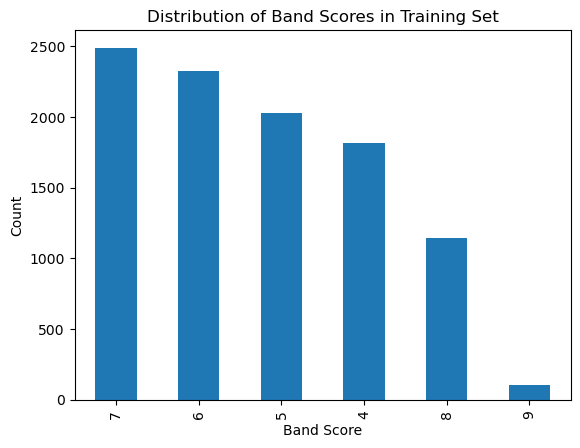

In [83]:
import matplotlib.pyplot as plt

# Check the distribution of band scores in the training set
train_df['band'].value_counts().plot(kind='bar')
plt.title('Distribution of Band Scores in Training Set')
plt.xlabel('Band Score')
plt.ylabel('Count')
plt.show()


In [84]:
import pandas as pd

# Assuming you have your train_df DataFrame ready
band_distribution = train_df['band'].value_counts().sort_index()

# Output the distribution as text
print("Distribution of Band Scores in Training Set:")
for band, count in band_distribution.items():
    print(f"Band {band}: {count} essays")


Distribution of Band Scores in Training Set:
Band 4: 1819 essays
Band 5: 2029 essays
Band 6: 2324 essays
Band 7: 2489 essays
Band 8: 1145 essays
Band 9: 106 essays


In [1]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset("chillies/IELTS_evaluations")

# Inspect the dataset
print(ds)


DatasetDict({
    train: Dataset({
        features: ['prompt', 'essay', 'evaluation', 'band'],
        num_rows: 9912
    })
    test: Dataset({
        features: ['prompt', 'essay', 'evaluation', 'band'],
        num_rows: 495
    })
})


In [2]:
# Show a sample from the dataset
print(ds['train'][0])


{'prompt': 'Young people who commit crimes should be treated in the same way as adults who commit crimes.\r\n\r\nTo what extent do you agree or disagree?', 'essay': 'Deciding to choose among the potential ways of punishing young people who commit crimes continues to be a controversial issue for the societies and the governments. It is argued by some that these people should be treated the same as adults. I personally disagree with this opinion due to the adverse effects of imprisonment on a teenager’s mental health.\r\n\r\nMany countries put the criminals of their society at jails considering it as a very effective way of punishment. It is understandable that this does exert a positive influence on decreasing crime in the society by putting the criminals in an unpleasant situation which they would mostly never wish to experience again. As a result, this could impede them from attempting crime in the future. For example, my friend who had been sent to jail for 2 months because of repeat

In [17]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Example mapping of string labels to integers
label_mapping = {
    
    "<4": 3,
    "4": 4,
    "4.5": 4.5,
    "5": 5,
    "5.0": 5,
    "5.5": 5.5,
    "6": 6,
    "6.5": 6.5,
    "7": 7,
    "7.5": 7.5,
    "8": 8,
    "8.5": 8.5,
    "9": 9,
    "9.5": 9.5
}

# Load and preprocess your dataset
class EssayDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.data['band'] = self.data['band'].apply(self.clean_label)  # Clean labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.preprocess_data(self.data.iloc[idx])

    def clean_label(self, label):
        # Clean the label by stripping any extra whitespace or special characters
        return label.strip()

    def preprocess_data(self, row):
        input_text = row['essay']
        # Tokenize the input text
        inputs = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}  # Remove batch dimension from inputs

        # Convert the label from string to integer
        label_str = row['band']
        if label_str not in label_mapping:
            raise ValueError(f"Unexpected label: {label_str}")
        label = label_mapping[label_str]  # Map the string label to an integer

        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': torch.tensor(label, dtype=torch.long)  # Ensure the label is a tensor of type long
        }

# Create Dataset objects
train_dataset = EssayDataset(train_df)
test_dataset = EssayDataset(test_df)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',                  
    per_device_train_batch_size=4,           
    per_device_eval_batch_size=4,            
    num_train_epochs=3,                      
    logging_dir='./logs',                    
    logging_steps=10,                        
    evaluation_strategy='steps',             
    save_steps=500,                          
    save_total_limit=2,                      
    load_best_model_at_end=True              
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


/Users/lidiiakliuchna/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/lidiiakliuchna/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weigh

Step,Training Loss,Validation Loss
10,2.407400,2.162059
20,2.179500,1.967232
30,1.947300,1.875708
40,1.914500,1.804510
50,1.769500,1.799212
60,1.786500,1.812740
70,1.904000,1.785557
80,1.782100,1.758752
90,1.901100,1.772043
100,1.758200,1.748389


TrainOutput(global_step=7434, training_loss=1.5994055881146176, metrics={'train_runtime': 58290.6156, 'train_samples_per_second': 0.51, 'train_steps_per_second': 0.128, 'total_flos': 7824713310683136.0, 'train_loss': 1.5994055881146176, 'epoch': 3.0})

In [18]:
# After training the model
model.save_pretrained('./results')  # Save the model to the specified directory
tokenizer.save_pretrained('./results')  # Save the tokenizer to the same directory


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json')

In [23]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define the label mapping
label_mapping = {
    "<4": 3,
    "4": 4,
    "4.5": 4.5,
    "5": 5,
    "5.0": 5,
    "5.5": 5.5,
    "6": 6,
    "6.5": 6.5,
    "7": 7,
    "7.5": 7.5,
    "8": 8,
    "8.5": 8.5,
    "9": 9,
    "9.5": 9.5
}

# Reverse the label mapping for decoding
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('./results')  # Load from the directory where you saved it
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_input(text, tokenizer):
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return inputs

def predict_label(text, model, tokenizer):
    model.eval()
    inputs = preprocess_input(text, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    predicted_label = inverse_label_mapping.get(predicted_class_id, "Unknown")
    return predicted_label

if __name__ == "__main__":
    user_input = input("Enter the essay text: ")
    predicted_label = predict_label(user_input, model, tokenizer)
    print(f"Predicted rating for the input essay: {predicted_label}")


Enter the essay text: "In recent years, many countries have reported a decrease in the number of students choosing science subjects in universities. This is a concerning trend that can have a profound impact on society. In this essay, I will discuss the reasons behind this problem and its implications. The first reason for fewer students selecting science subjects is likely that these courses are difficult to comprehend. In general, science courses such as mathematics and physics involve complex theories, formulas, and concepts that require a great deal of hard work to understand. Furthermore, they are often taught in a theoretical manner and fail to show students how this knowledge can be used in real life. In other words, it may seem impractical for them to learn science courses. Lastly, it may be hard to acquire a practical job through these theoretical subjects in the future. As a result, students may give up studying science because they find scientific studies unappealing, imprac

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from datasets import load_dataset
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the label mapping
label_mapping = {
    "<4": 3,
    "4": 4,
    "4.5": 4.5,
    "5": 5,
    "5.0": 5,
    "5.5": 5.5,
    "6": 6,
    "6.5": 6.5,
    "7": 7,
    "7.5": 7.5,
    "8": 8,
    "8.5": 8.5,
    "9": 9,
    "9.5": 9.5
}

# Reverse the label mapping for decoding
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Load the dataset
dataset = load_dataset("chillies/IELTS_evaluations")

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('./results')  # Path to your model directory
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_input(text, tokenizer):
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return inputs

def predict_label(text, model, tokenizer):
    model.eval()
    inputs = preprocess_input(text, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    # Ensure prediction is numeric and exists in label_mapping
    return predicted_class_id

# Prepare for evaluation
predictions = []
real_labels = []

# Process the test split
for example in dataset['test']:
    text = example['essay']
    real_label_str = example['band']
    
    # Predict label
    predicted_class_id = predict_label(text, model, tokenizer)
    
    # Convert real label string to numeric value
    real_label = label_mapping.get(real_label_str, None)
    if real_label is not None:
        predictions.append(predicted_class_id)
        real_labels.append(real_label)

# Convert lists to numpy arrays for comparison
predictions = np.array(predictions)
real_labels = np.array(real_labels)

# Print some examples for debugging
print("Example predictions:", predictions[:10])
print("Example real labels:", real_labels[:10])

# Calculate accuracy
accuracy = np.mean(predictions == real_labels)
print(f"Accuracy: {accuracy:.4f}")

# For more detailed evaluation, consider metrics like Mean Squared Error (MSE) or Mean Absolute Error (MAE)
# Ensure predictions are in float format for MSE and MAE
predictions = predictions.astype(float)
real_labels = real_labels.astype(float)

mse = mean_squared_error(real_labels, predictions)
mae = mean_absolute_error(real_labels, predictions)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


/Users/lidiiakliuchna/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Example predictions: [7 6 7 3 7 7 6 7 4 6]
Example real labels: [8.5 5.  6.  3.  6.5 8.  6.  7.5 5.  5.5]
Accuracy: 0.2917
Mean Squared Error: 1.0625
Mean Absolute Error: 0.7500


In [28]:
# Check the mapping of labels
print("Label Mapping:", label_mapping)


Label Mapping: {'<4': 3, '4': 4, '4.5': 4.5, '5': 5, '5.0': 5, '5.5': 5.5, '6': 6, '6.5': 6.5, '7': 7, '7.5': 7.5, '8': 8, '8.5': 8.5, '9': 9, '9.5': 9.5}


In [30]:
# Print some predictions and corresponding real labels for debugging
for pred, real in zip(predictions[:10], real_labels[:10]):
    print(f"Predicted: {pred}, Actual: {real}")


Predicted: 7.0, Actual: 8.5
Predicted: 6.0, Actual: 5.0
Predicted: 7.0, Actual: 6.0
Predicted: 3.0, Actual: 3.0
Predicted: 7.0, Actual: 6.5
Predicted: 7.0, Actual: 8.0
Predicted: 6.0, Actual: 6.0
Predicted: 7.0, Actual: 7.5
Predicted: 4.0, Actual: 5.0
Predicted: 6.0, Actual: 5.5


In [31]:
from sklearn.metrics import r2_score

# Example additional metric
r2 = r2_score(real_labels, predictions)
print(f"R-squared: {r2:.4f}")


R-squared: 0.4312


In [34]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define the label mapping
label_mapping = {
    "<4": 3,
    "4": 4,
    "4.5": 4.5,
    "5": 5,
    "5.0": 5,
    "5.5": 5.5,
    "6": 6,
    "6.5": 6.5,
    "7": 7,
    "7.5": 7.5,
    "8": 8,
    "8.5": 8.5,
    "9": 9,
    "9.5": 9.5
}

# Reverse the label mapping for decoding
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('./results')  # Load from the directory where you saved it
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_input(text, tokenizer):
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return inputs

def predict_label(text, model, tokenizer):
    model.eval()
    inputs = preprocess_input(text, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    predicted_label = inverse_label_mapping.get(predicted_class_id, "Unknown")
    return predicted_label

def provide_feedback(predicted_label, target_label):
    predicted_value = float(predicted_label)
    target_value = float(target_label)
    
    if predicted_value == target_value:
        feedback = f"Your essay has been rated as {predicted_label}. Well done, you met your target!"
    elif predicted_value > target_value:
        feedback = f"Your essay has been rated as {predicted_label}. Excellent! You've exceeded your target of {target_label}."
    else:
        feedback = f"Your essay has been rated as {predicted_label}. Keep working on it to reach your target of {target_label}."
    
    return feedback

if __name__ == "__main__":
    user_input = input("Enter the essay text: ")
    target_band = input("Enter your target band score: ")  # User provides the target score
    
    predicted_label = predict_label(user_input, model, tokenizer)
    print(f"Predicted rating for the input essay: {predicted_label}")
    
    feedback = provide_feedback(predicted_label, target_band)
    print(feedback)


Enter the essay text: "There is currently a material issue that while the majority of students are eager to learn business or art in university, there are only a few students who want to study science, leading to numerous negative effects on community. With respect to this matter, there are also a wide variety of factors that influence the decision of students to not study science subjects. It is undeniable that there are many reasons why undergraduates avoid studying science. A classic example of this is that science is extremely difficult to understand. In order to fully comprehend a particular scientific phenomenon, students have to learn complex theories that cause the phenomena. Therefore, they tend to choose other subjects that are easier to understand. Another common reason is a small amount of salary for working in scientific fields. When student choose subjects to study at university, they tend to enroll in an area that they could make a lot of money from having that knowledge

In [36]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define the label mapping
label_mapping = {
    "<4": 3,
    "4": 4,
    "4.5": 4.5,
    "5": 5,
    "5.0": 5,
    "5.5": 5.5,
    "6": 6,
    "6.5": 6.5,
    "7": 7,
    "7.5": 7.5,
    "8": 8,
    "8.5": 8.5,
    "9": 9,
    "9.5": 9.5
}

# Reverse the label mapping for decoding
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('./results')  # Load from the directory where you saved it
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_input(text, tokenizer):
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return inputs

def predict_label(text, model, tokenizer):
    model.eval()
    inputs = preprocess_input(text, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    predicted_label = inverse_label_mapping.get(predicted_class_id, "Unknown")
    return predicted_label

def generate_feedback(predicted_label, text):
    # Placeholder feedback; in a real scenario, this would involve more complex NLP processing
    feedback = f"Band Score (Coherence and Cohesion): {predicted_label}\n"
    
    # Example of feedback for Lexical Resource
    feedback += "## Lexical Resource (Vocabulary):\n"
    feedback += "- **Mistake**: \"there for\"\n"
    feedback += "- **Rectified**: therefore\n"
    feedback += "- **Mistake**: \"pity crimes\"\n"
    feedback += "- **Rectified**: minor offenses\n"
    feedback += "The candidate demonstrates a good range of vocabulary, using a variety of words and phrases to express their ideas. However, there are a few minor inaccuracies and overused words, such as \"imprisonment\" and \"adverse effects,\" which could be replaced with more precise or varied vocabulary.\n"
    feedback += f"Suggested Band Score (Lexical Resource): {float(predicted_label) - 0.5}\n\n"
    
    # Example of feedback for Grammatical Range and Accuracy
    feedback += "## Grammatical Range and Accuracy:\n"
    feedback += "- **Mistake**: \"It is understandable that this does exert a positive influence on decreasing crime in the society by putting the criminals in an unpleasant situation which they would mostly never wish to experience again\"\n"
    feedback += "- **Rectified**: It is understandable that this exerts a positive influence on decreasing crime in society by putting criminals in an unpleasant situation that they would mostly never wish to experience again.\n"
    feedback += "- **Mistake**: \"For there, sending them to prison like adults as a way of punishment for their crimes, which are most often pity crimes, would actually expose them to other criminals who might have some serious personality disorders and this would adversely affect their personality as an adult in the future\"\n"
    feedback += "- **Rectified**: However, sending them to prison like adults as a way of punishment for their crimes, which are most often pity crimes, would expose them to other criminals who might have serious personality disorders, and this would adversely affect their personality as adults in the future.\n"
    feedback += "The essay demonstrates a good range of sentence structures but could benefit from more variety and complexity. There are also a few grammatical errors, particularly in the use of prepositions and sentence construction, which could be corrected for greater accuracy.\n"
    feedback += f"Suggested Band Score (Grammatical Range and Accuracy): {float(predicted_label) - 0.5}\n\n"
    
    # Overall feedback
    feedback += f"## Overall Band Score: Considering the essay's overall performance across all criteria, a suggested overall band score would be {float(predicted_label) - 0.5}.\n"
    feedback += "The essay addresses the task effectively, is well-organized, and demonstrates a good range of vocabulary and grammar. However, some minor inaccuracies and grammatical errors could be improved for greater precision and clarity.\n\n"
    
    # Additional comments
    feedback += "## Feedback and Additional Comments:\n"
    feedback += "Strengths:\n"
    feedback += "- The essay is well-organized and easy to follow.\n"
    feedback += "- The arguments are supported with relevant examples.\n"
    feedback += "- The candidate demonstrates a good understanding of the topic.\n\n"
    
    feedback += "Areas for Improvement:\n"
    feedback += "- Expand the vocabulary by using more precise and varied words and phrases.\n"
    feedback += "- Edit for grammatical errors to enhance accuracy and clarity.\n"
    feedback += "- Consider using more complex sentence structures to demonstrate a wider range of grammatical ability.\n\n"
    
    feedback += "Additional Suggestions:\n"
    feedback += "- To enhance vocabulary, the candidate could read more widely and expose themselves to a variety of texts.\n"
    feedback += "- To improve grammatical accuracy, the candidate could practice writing regularly and seek feedback from a teacher or language partner.\n"
    
    return feedback

if __name__ == "__main__":
    user_input = input("Enter the essay text: ")
    
    predicted_label = predict_label(user_input, model, tokenizer)
    print(f"Predicted Band Score: {predicted_label}\n")
    
    feedback = generate_feedback(predicted_label, user_input)
    print(feedback)


Enter the essay text: "There is currently a material issue that while the majority of students are eager to learn business or art in university, there are only a few students who want to study science, leading to numerous negative effects on community. With respect to this matter, there are also a wide variety of factors that influence the decision of students to not study science subjects. It is undeniable that there are many reasons why undergraduates avoid studying science. A classic example of this is that science is extremely difficult to understand. In order to fully comprehend a particular scientific phenomenon, students have to learn complex theories that cause the phenomena. Therefore, they tend to choose other subjects that are easier to understand. Another common reason is a small amount of salary for working in scientific fields. When student choose subjects to study at university, they tend to enroll in an area that they could make a lot of money from having that knowledge